In [50]:
from tensorflow import keras
from Stats import Splitter
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.models import Model
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten
import matplotlib.pyplot as plt
import pickle
import math
np.random.seed(42)

In [2]:
df = pickle.load(open('scaled_df.pkl', 'rb'))
df = df.fillna(0)
df

,AvgFramesLeftTurn,AvgFramesRightTurn,AvgFramesMerge,AvgFramesUTurn,IntersectionMaxAcc,IntersectionAvgAcc,IntersectionVarAcc,IntersectionMaxYaw,IntersectionAvgYaw,IntersectionVarYaw,...,MergeMaxYaw,MergeAvgYaw,MergeVarYaw,UTurnMaxAcc,UTurnAvgAcc,UTurnVarAcc,UTurnMaxYaw,UTurnAvgYaw,UTurnVarYaw,Date
0,0.022657,-0.841095,0.000000,0.000000,-0.034730,0.569793,-0.107249,-0.677880,-0.170996,-0.322533,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.303128
1,-0.814371,-1.018391,0.000000,0.000000,-0.062706,0.447115,-0.703907,1.006835,-1.213577,1.010875,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.303128
2,-0.256352,-0.663798,0.000000,0.000000,-0.342463,-0.680043,-0.061242,-0.607683,0.184810,-0.363580,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.303128
3,0.000000,-1.018391,0.000000,0.000000,0.105148,-0.174470,-0.081112,-0.046111,-0.134974,-0.278161,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.303128
4,-0.814371,-0.841095,0.000000,0.000000,-0.370438,-0.420949,-0.385951,1.989586,-0.899950,3.905272,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.303128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1365,0.022657,0.000000,0.000000,0.000000,0.776564,1.722847,0.350910,0.024085,-0.397178,-0.253835,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.806791
1366,0.208663,-0.309205,0.000000,-0.276598,0.412880,-0.561455,0.233737,1.428014,0.891668,-0.072600,...,0.000000,0.000000,0.000000,0.862328,0.486498,1.014324,-0.270132,-0.263974,0.501930,1.806791
1367,0.301666,0.000000,0.000000,2.330281,0.245026,1.014603,0.014600,-0.467290,-0.127200,-0.230330,...,0.000000,0.000000,0.000000,0.337165,0.174637,0.217262,0.473558,0.797583,-0.646166,1.806791
1368,-0.256352,0.000000,-0.046796,0.000000,-0.398414,-1.162508,0.152984,-0.537487,0.358867,-0.362286,...,-0.210055,-0.126709,-0.321549,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.806791


In [3]:
train_df = df[:1000]
val_df = df[1000:]
enrollment_df = val_df[(val_df.index % 10 < 5)]
verification_df = val_df[(val_df.index % 10 >= 5)]

In [61]:
train_data = train_df.to_numpy()
train_X = train_data[:, :-1]
train_Y = train_data[:, -1]
label_encoder = LabelEncoder()
train_integer_encoded = label_encoder.fit_transform(train_Y)
onehot_encoder = OneHotEncoder(sparse=False)
train_integer_encoded = train_integer_encoded.reshape(len(train_integer_encoded), 1)
train_Y_encoded = onehot_encoder.fit_transform(train_integer_encoded)
train_X = np.reshape(train_X, (1000, 8, 8))
train_Y_encoded

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [62]:
kernel_size = 3
filters = 256

cnn_model = Sequential()
cnn_model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1, input_shape= (8, 8)))
cnn_model.add(MaxPooling1D())
cnn_model.add(Conv1D(filters/2, kernel_size, padding='same', activation='relu', strides=1, input_shape= (6, filters)))
cnn_model.add(MaxPooling1D())
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(100, activation='softmax'))
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_23 (Conv1D)           (None, 6, 256)            6400      
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 3, 256)            0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 3, 128)            98432     
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 1, 128)            0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_13 (Dense)             (None, 100)             

In [33]:
cnn_model.fit(train_X, train_Y_encoded, epochs=200, batch_size=20, shuffle=True)

Epoch 1/200
50/50 [==============================] - 1s 2ms/step - loss: 4.5995 - accuracy: 0.0080
Epoch 2/200
50/50 [==============================] - 0s 2ms/step - loss: 4.4373 - accuracy: 0.0290
Epoch 3/200
50/50 [==============================] - 0s 2ms/step - loss: 4.2100 - accuracy: 0.0560
Epoch 4/200
50/50 [==============================] - 0s 2ms/step - loss: 3.8961 - accuracy: 0.1070
Epoch 5/200
50/50 [==============================] - 0s 2ms/step - loss: 3.6312 - accuracy: 0.1260
Epoch 6/200
50/50 [==============================] - 0s 2ms/step - loss: 3.3422 - accuracy: 0.1930
Epoch 7/200
50/50 [==============================] - 0s 2ms/step - loss: 3.0751 - accuracy: 0.2250
Epoch 8/200
50/50 [==============================] - 0s 2ms/step - loss: 2.8208 - accuracy: 0.2850
Epoch 9/200
50/50 [==============================] - 0s 2ms/step - loss: 2.5902 - accuracy: 0.3380
Epoch 10/200
50/50 [==============================] - 0s 2ms/step - loss: 2.3897 - accuracy: 0.3820
Epoch 11/

In [40]:
predictions = Dense(100, activation='softmax')(cnn_model.layers[-3].output)
model = Model(inputs=cnn_model.inputs, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy')
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21_input (InputLayer) [(None, 8, 8)]            0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 6, 256)            6400      
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 3, 256)            0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 3, 128)            98432     
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 1, 128)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 100)               1290

In [44]:
enrollment_data = enrollment_df.to_numpy()
verification_data = verification_df.to_numpy()
enrollment_data = enrollment_data[:, :-1]
verification_data = verification_data[:, :-1]
enrollment_data = np.reshape(enrollment_data, (185, 8, 8))
verification_data = np.reshape(verification_data, (185, 8, 8))
enrollment_pred = model.predict(enrollment_data)
verification_pred = model.predict(verification_data)

In [45]:
agg_enrollment_pred = np.mean(enrollment_pred.reshape(-1, 5, 100), axis=1)
agg_verification_pred = np.mean(verification_pred.reshape(-1, 5, 100), axis=1)
agg_verification_pred.shape

(37, 100)

In [46]:
# Generate (s, s) pairs
authorized_pairs = []
for i in range(len(agg_verification_pred)):
    pair = (agg_enrollment_pred[i], agg_verification_pred[i])
    authorized_pairs.append(pair)
imposter_pairs = []
# Generate (s, i) pairs
for i in range(len(agg_verification_pred)):
    random_i = i
    while random_i == i:
        random_i = np.random.randint(36)
    pair = (agg_enrollment_pred[i], agg_verification_pred[random_i])
    imposter_pairs.append(pair)

In [59]:
'''Similarity score between 0 and 1 - 1 indicates identical, 0 indicates entirely different'''
def dist_to_similarity(dist: float):
    similarity = math.exp(-(dist**2))
    return similarity

def calc_false_rejection(threshold: float):
    count = 0
    for i in range(len(authorized_pairs)):
        dist = np.linalg.norm(authorized_pairs[i][0] - authorized_pairs[i][1])
        similarity = dist_to_similarity(dist)
        if similarity < threshold:
            # Authorized user is rejected
            count += 1
    return count/len(authorized_pairs)

def calc_false_acceptance(threshold: float):
    count = 0
    for i in range(len(imposter_pairs)):
        dist = np.linalg.norm(authorized_pairs[i][0] - authorized_pairs[i][1])
        similarity = dist_to_similarity(dist)
        if similarity > threshold:
            count += 1
    return count/len(imposter_pairs)


In [54]:
false_rejection_scores = []
false_acceptance_scores = []
thresholds = [x * 0.05 for x in range(0, 40)]
for threshold in thresholds:
    false_rejection = calc_false_rejection(threshold)
    false_accpetance = calc_false_acceptance(threshold)
    false_rejection_scores.append(false_rejection)
    false_acceptance_scores.append(false_accpetance)

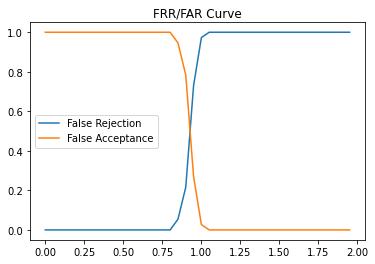

In [55]:
plt.plot(thresholds, false_rejection_scores, label='False Rejection')
plt.plot(thresholds, false_acceptance_scores, label='False Acceptance')
plt.title('FRR/FAR Curve')
plt.legend(loc='center left')
plt.show()

In [ ]:
model = Sequential()
model.add(Dense(512, input_dim=64, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(100, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()